### Sub-questions
To answer our main research question and to support statements made in the introduction, a few sub questions have been created.

1. How have the prices of fuels developed over the years?
2.
3.
4. Long term/short term effects?


## 1.Introduction
Gas prices have been a highly controversial topic since the Covid-19 crisis of 2020 and the start of the Russia-Ukraine war in Februari 2022 as gas is the main fuel for the transportation sector. The costs of the transportation sector can be split in fixed costs and variable costs, where fuel prices are the most important part of the variable costs. It is therefore interesting to see the correlation between the price of gas and the use of various modes of transportation. Trains, ships and trucks are the main modes for the transportation of goods as their efficiency over long distances with high loads is relatively low. 

## 2. Analysis of fuel prices

<class 'numpy.float64'>


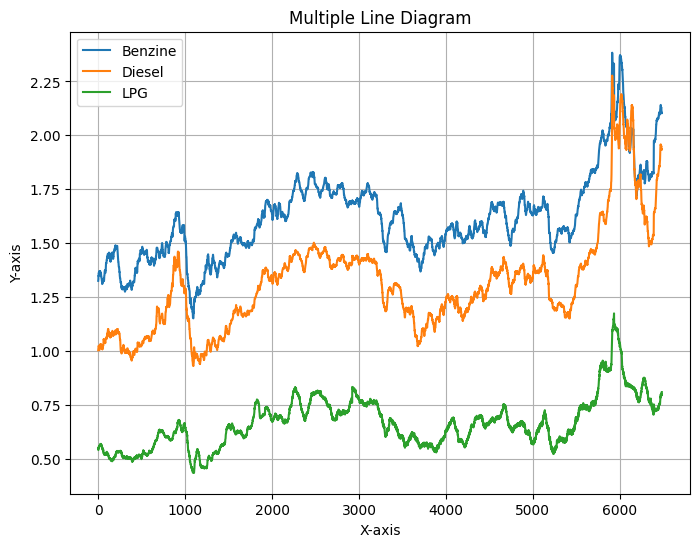

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

fuel = pd.read_csv("data/fuel.csv", sep=";")[:-1]
fuel = fuel.replace(',','.', regex = True)
fuel[["Benzine","Diesel","LPG"]] = fuel[["Benzine", "Diesel","LPG"]].map(lambda x: float(x))


dates = [date.split(sep= " ") for date in fuel["Perioden"]]
fuel["Jaar"] = [int(date[0]) for date in dates]

dct = {"januari": 1, "februari": 2, "maart": 3, "april": 4, "mei": 5, "juni": 6,\
        "juli":7, "augustus": 8, "september":9, "oktober":10, "november":11, "december":12}
fuel["Maand"] = [dct[date[-1]] for date in dates]
fuel["Kwartaal"] = [1+(maand-1)//3 for maand in fuel["Maand"]]
fuel.head()

x_data = fuel["Jaar"] + (fuel["Kwartaal"]-1)/4
y1_data = fuel["Benzine"]
y2_data = fuel["Diesel"]
y3_data = fuel["LPG"]
print(type(y1_data[0]))

plt.figure(figsize=(8, 6))  
plt.plot(y1_data, label='Benzine')  
plt.plot(y2_data, label='Diesel')  
plt.plot(y3_data, label='LPG')  


plt.title('Multiple Line Diagram')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines if needed
plt.show()